# Segment Anything 微调

SAM 全部微调需求的内存是巨大的，没有大显卡的朋友不要跑这一章。

# 一、环境准备

## 1.检查 CUDA 状态

多卡需禁用，或者运行后重启内核。

In [1]:
import torch

def check_cuda():
    flag = torch.cuda.is_available()
    if flag:
        print("CUDA可使用")
    else:
        print("CUDA不可用")

    # 获取GPU数量
    ngpu = torch.cuda.device_count()
    print("GPU数量：",ngpu)
    # Decide which device we want to run on
    device = torch.device("cuda:1" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    print("驱动为：",device)
    print("GPU型号： ",torch.cuda.get_device_name(0))


check_cuda()

CUDA可使用
GPU数量： 2
驱动为： cuda:1
GPU型号：  NVIDIA GeForce RTX 3090


## 2.环境超参

In [2]:
from argparse import Namespace
import sys
sys.path.insert(0, '..')

config = Namespace(
    img_size = 128,
    lr = 1e-4,
    batch_size = 4,
    num_workers = 2,
)

# 二、数据准备

## 1.定义数据增强方式

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


def create_transform():
    train_transforms = A.Compose(
        [
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
            ]),
            A.Resize(
                height=256, width=256, p=1.0
            ),
            ToTensorV2(p=1),
        ],
        p=1.0,
        keypoint_params=A.KeypointParams(format='yx')
    )
    val_transforms = A.Compose(
        [
            A.Resize(
                height=256, width=256, p=1.0
            ),
            ToTensorV2(p=1),
        ],
        p=1.0,
        keypoint_params=A.KeypointParams(format='yx')
    )
    return train_transforms, val_transforms

## 2.定义 dataset 和 dataloader

In [4]:
from custom.datasets.isic2016 import ISIC2016Dataset
from pathlib import Path
import torch
import torch.utils
import torchvision

from torch.utils.data import DataLoader, ConcatDataset


def create_dataset():
    train_imgs = [
        str(x) for x in Path("/home/zijieshen/new_disk/datasets/ISIC2016/P1/Train").rglob("*.jpg")
        if "checkpoint" not in str(x)
    ]
    val_imgs = [
        str(x) for x in Path("/home/zijieshen/new_disk/datasets/ISIC2016/P1/Val").rglob("*.jpg")
        if "checkpoint" not in str(x)
    ]
    train_ts, val_ts = create_transform()
    train_ds = ISIC2016Dataset(
        img_files=train_imgs, transforms=train_ts
    )
    val_ds = ISIC2016Dataset(
        img_files=val_imgs, transforms=val_ts
    )
    return train_ds, val_ds


def create_dataloader(train_ds=None, val_ds=None):
    if train_ds is None or val_ds is None:
        train_ds, val_ds = create_dataset()

    train_dl = DataLoader(
        train_ds, batch_size=config.batch_size,
        shuffle=False, num_workers=config.num_workers
    )
    val_dl = DataLoader(
        val_ds, batch_size=config.batch_size,
        shuffle=False, num_workers=config.num_workers
    )
    return train_dl, val_dl

train_dataset, val_dataset = create_dataset()
train_dataloader, val_dataloader = create_dataloader(train_dataset, val_dataset)



## 3.检查数据

(256, 256, 3) (256, 256)


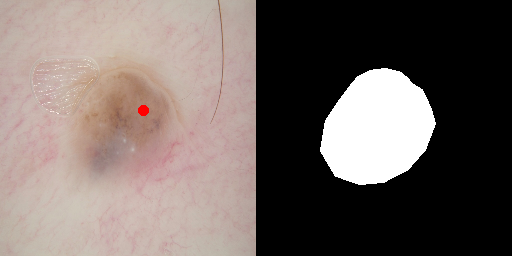

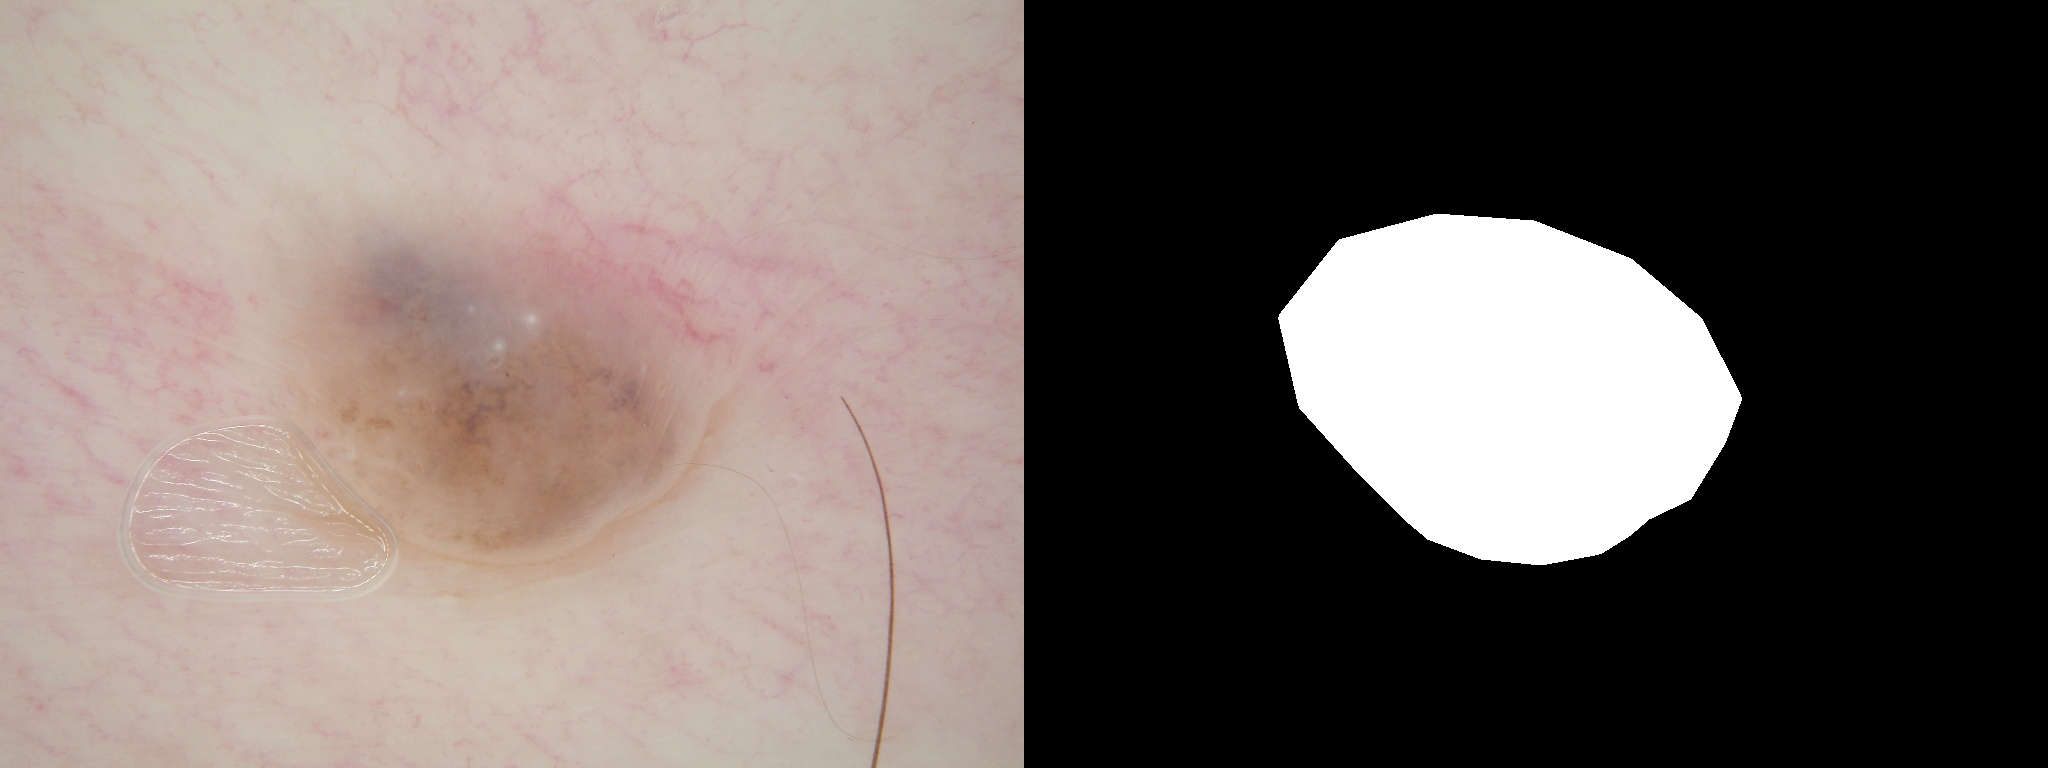

In [5]:
import numpy as np
from PIL import Image
from PIL import ImageDraw
from torchkeras.plots import joint_imgs_row

for batch in train_dataloader:
    image = batch['image']
    mask = batch['mask']
    point = batch['keypoints']
    point_label = batch['point_label']

    # tensor -> numpy -> PIL
    image = image[0].permute(1, 2, 0).numpy()
    mask = mask[0].permute(1, 2, 0).numpy().squeeze()
    mask = np.where(mask > 0.5, 255, 0).astype(np.uint8)

    point = point[0].numpy()
    point_label = point_label[0].numpy()

    print(image.shape, mask.shape)

    image = Image.fromarray(image.astype(np.uint8))
    mask = Image.fromarray(mask)
    # 画点
    image_draw = ImageDraw.Draw(image)
    for p in point:
        p[0], p[1] = p[1], p[0]
        # 绘制一个圆
        image_draw.ellipse([p[0] - 5, p[1] - 5, p[0] + 5, p[1] + 5], fill='red')

    display(joint_imgs_row(image, mask))
    break

display(train_dataset.show_sample(0))


# 三、训练准备

## 1.定义模型

### 1.定义模型

In [6]:
from segment_anything import sam_model_registry


sam = sam_model_registry["vit_b"](checkpoint="../checkpoints/sam/sam_vit_b_01ec64.pth")


### 2.参数统计 (可选)

In [7]:
mdp_num = sum(p.numel() for p in sam.mask_decoder.parameters()) 
iep_num = sum(p.numel() for p in sam.image_encoder.parameters()) 
pdp_num = sum(p.numel() for p in sam.prompt_encoder.parameters()) 

print(
    f"mask_decoder parameter number: {mdp_num} \n",
    f"image_encoder parameter number: {iep_num} \n",
    f"prompt_encoder parameter number: {pdp_num} \n",
    f"total parameter number: {mdp_num + iep_num + pdp_num}"
)

mask_decoder parameter number: 4058340 
 image_encoder parameter number: 89670912 
 prompt_encoder parameter number: 6220 
 total parameter number: 93735472


## 2.定义 PEFT，此处为 Lora

### 1.选择需要 PEFT 的层

In [8]:
target_modules = [
    "image_encoder.blocks.{}.attn.qkv".format(i) for i in range(12)
]

### 2.设置 lora，并得到 lora 模型

In [9]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(target_modules=target_modules, r=8)
sam_lora = get_peft_model(sam, lora_config)
print(sam_lora)

KeyboardInterrupt: 

### 3.选择参与剃度下降的层

PEFT 包会将原网络中的所有层冻住，只有 PEFT 层处于激活状态，所以如果需要训练原网络的其他层，这里需要进行手动解冻。（如果只需要 PEFT，则跳过这一节）

这里我们只希望训练 Lora 和 mask_decoder 部分，所以只需要手动解冻 mask_decoder 层。

In [10]:
for param in sam_lora.base_model.model.mask_decoder.parameters():
    param.requires_grad = True

print(f"lora sam parameter number: {sum(p.numel() for p in sam_lora.parameters())}")

lora sam parameter number: 94030384


### 4.检查参数梯度下降的层

In [11]:
sam_lora.train()
for name, param in sam_lora.named_parameters():
    if param.requires_grad:
        print(name)

base_model.model.image_encoder.blocks.0.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.0.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.1.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.1.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.2.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.2.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.3.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.3.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.4.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.4.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.5.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.5.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.6.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.6.attn.qkv.lora_B.default.weight
base_m

## 3.定义 loss、optimizer、lr_schedulaer、metrics_dict

这里和前面的不同地方在于，Adam 只接收需要训练的参数，前面的参数是全部参与训练，而这里是部分，所以需要进行过滤。

In [12]:
import torch
from torchkeras.metrics import IOU
from torchkeras.kerasmodel import KerasModel
from custom.loss import MixedLoss, DiceLoss

optim = torch.optim.Adam(filter(
    lambda p: p.requires_grad, sam_lora.parameters()
), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=8, eta_min=1e-6
)
metrics = {
    "iou": IOU(num_classes=1)
}


## 4.定义 torchkeras 模型

In [13]:
model = KerasModel(
    sam_lora, loss_fn=MixedLoss(0.5), optimizer=optim,
    lr_scheduler=lr_scheduler, metrics_dict=metrics
)

## 5.定义训练 StepRunner

In [14]:
from importlib import reload
from torchkeras import kerasmodel, pbar
from custom.step import StepRunner

# reload(kerasmodel)
# reload(pbar)

kerasmodel.KerasModel.StepRunner = StepRunner

# 四、训练

## 1.Wandb记录、VisDisplay展示

In [15]:
from importlib import reload
from torchkeras import kerasmodel, kerascallbacks
reload(kerascallbacks)

from torchkeras.kerascallbacks import WandbCallback
from torchkeras.kerascallbacks import VisDisplay


def display_fn(model):
    from matplotlib import pyplot as plt
    batch = next(iter(val_dataloader))

    with torch.no_grad():
        model.eval()
        logits = model(batch["image"].cuda())
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"][:2], batch["mask"][:2], pr_masks[:2]):
        plt.figure(figsize=(16, 10))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")

        plt.show()


wandb_cb = WandbCallback(
    project='lane_lines',
    config=config.__dict__,
    name=None,
    save_code=True,
    save_ckpt=True,
)

visdis_cb = VisDisplay(display_fn,model = model,init_display=False)


## 2.单卡训练

<<<<<< ⚡️ cuda is used >>>>>>


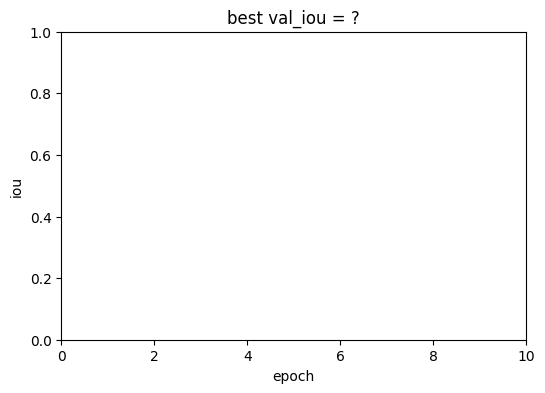

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zijie-shen795 (uestc-cd). Use `wandb login --relogin` to force relogin


Output()

ValueError: Caught ValueError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/zijieshen/PycharmProjects/pySEG/examples/../custom/datasets/isic2016.py", line 46, in __getitem__
    sample = self.transforms(**sample)
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/albumentations/core/composition.py", line 228, in __call__
    p.preprocess(data)
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/albumentations/core/utils.py", line 90, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/albumentations/core/utils.py", line 104, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/albumentations/core/keypoints_utils.py", line 127, in convert_to_albumentations
    return convert_keypoints_to_albumentations(
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/albumentations/core/keypoints_utils.py", line 255, in convert_keypoints_to_albumentations
    return [
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/albumentations/core/keypoints_utils.py", line 256, in <listcomp>
    convert_keypoint_to_albumentations(kp, source_format, rows, cols, check_validity, angle_in_degrees)
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/albumentations/core/keypoints_utils.py", line 209, in convert_keypoint_to_albumentations
    check_keypoint(keypoint, rows, cols)
  File "/home/zijieshen/anaconda3/envs/pySEG/lib/python3.9/site-packages/albumentations/core/keypoints_utils.py", line 141, in check_keypoint
    raise ValueError(f"Expected {name} for keypoint {kp} to be in the range [0.0, {size}], got {value}.")
ValueError: Expected y for keypoint (195, 853, 0.0, 0.0) to be in the range [0.0, 768], got 853.


In [16]:

dfhistory=model.fit(
    train_data=train_dataloader,
    val_data=val_dataloader,
    epochs=40,
    ckpt_path='checkpoint.pt',
    patience=5,
    monitor="val_iou",
    mode="max",
    mixed_precision='no',
    callbacks = [wandb_cb,visdis_cb],
    plot=True,
    cpu=False,
    quiet=True,
)
